In [1]:
#data loading
import pandas as pd
predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Transfers/Datasets/2transfers_rund_10-90.csv', low_memory = False)

In [2]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [25, 24]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

In [4]:
#bins amount
#transfers: 10m - 25.123 / 1M - 35.8775 / 2M - 37.3285 / 3M - 38.2194 / 4M - 38.818 / 5M - 39.3326 / gans - 26.3159 / imbalanced - 24.7233
#payments: 10m -  / 1M - 36.7452 / 2M - 38.2134 / 3M - 39.1709 / 4M - 39.8368 / 5M - 40.2234 / gans - 24.8089 / imbalanced - 22.5533

#bins accountbalance
#transfers: 10m - 24.6482 / 1M - 37.0555 / 2M - 38.5003 / 3M - 39.4439 / 4M - 40.1224 / 5M - 40.627 / gans - 25.734 / imbalanced - 23.9742
#payments: 10m - / 1M - 37.234 / 2M - 38.6645 / 3M - 39.651 / 4M - 40.2506 / 5M - 40.7402 / gans - 26.0935 / imbalanced - 20.7986

In [3]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [9]:
#interval that a word corresponds to
#values_map['apbicndke']

Interval(34055.72399772817, 50124.37964687015, closed='right')

In [4]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [5]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}

predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [6]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [7]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug', 
                        '9': 'sep', '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [8]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [9]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [10]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [11]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [12]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [13]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [14]:
#-----------------------------------------------------training----------------------------------------------------------------#

#inicialization and training word2vec 
import multiprocessing
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def training(sentences, dim, sample, negative, alpha, min_alpha):
    model = MyWord2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = dim,  #dimension of the embedding space 
        window = 1,  #words befores and after the center word 
        sample = sample,  #whithout subsampling 
        min_count = 1,  #use every word 
        negative = negative,  #noise-words 
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = alpha,  #initial learning rate 
        min_alpha = min_alpha,  #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs = 150, total_examples = model.corpus_count, compute_loss = True, callbacks = [])

    return model

In [21]:
#-----------------------------------------------------prediction-------------------------------------------------------------#

#update probv - vector with the parameters of a transaction
from scipy.special import softmax

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(my_model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(my_model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")

    #threshold for false negatives
    # if fraud_probv > threshold: return 1

    if fraud_probv > nfraud_probv:
        return 1
    
    return 0

In [22]:
#prediction method   
def predict(model, X, verbose1, verbose2):
    #save the predictions made by the model in a list
    predictions = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)

    return predictions

In [23]:
#convert true values for the train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [24]:
#convert true values of the test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [19]:
#grid-search
import os
from mlflow import log_metric, log_param, log_artifact
import mlflow
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

#create a hyperparameters dictionary 
dim = [2, 5]   
negative = [5, 10] #0 leads to not having the syn1neg property
alpha = [0.025, 0.035] 
min_alpha = [0.0001, 0.001] 
sample = [0, 0.001, 0.01]

#train the model 
i = 0
for d in dim:
    for n in negative:
        for a in alpha:
            for m in min_alpha:
                for s in sample:
                    i+=1
                    with mlflow.start_run(nested=True):

                        # Log params to mlflow
                        log_param("dim", d)
                        log_param("negative", n)
                        log_param("alpha", a)
                        log_param("min_alpha", m)
                        log_param("sample", s)

                        curr_model = training(sentences_series_np_train, dim = d, sample = s, negative = n, alpha = a, min_alpha = m)

                        #metrics for each combination - train
                        prevs_train = predict(curr_model, sentences_series_np_train, verbose1 = False, verbose2 = False)
                        precision_train, recall_train, fscore_train, _ = precision_recall_fscore_support(y_train, prevs_train, average='micro')
                        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, prevs_train).ravel()
                        
                        log_param("precision_train", precision_train)
                        log_param("recall_train", recall_train)
                        log_param("f1_train", fscore_train)
                        log_param("tn_train", tn_train)
                        log_param("fp_train", fp_train)
                        log_param("fn_train", fn_train)
                        log_param("tp_train", tp_train)

                        #save current model
                        curr_model.save("trained_model.w2v")
                        log_artifact("trained_model.w2v")
                        os.remove("trained_model.w2v")

Validation loss decreased (inf --> 126069.562500).  Saving model ...
Validation loss decreased (126069.562500 --> 96918.515625).  Saving model ...
Validation loss decreased (96918.515625 --> 91100.921875).  Saving model ...
Validation loss decreased (91100.921875 --> 87750.062500).  Saving model ...
Validation loss decreased (87750.062500 --> 42644.937500).  Saving model ...
Validation loss decreased (42644.937500 --> 41914.906250).  Saving model ...
Validation loss decreased (41914.906250 --> 40966.781250).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (40966.781250 --> 39537.437500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (39537.437500 --> 38778.875000).  Saving model ...
Validation loss decreased (38778.875000 --> 38454.187500).  Saving model ...
Validation loss decreased (38454.187500 --> 37776.500000).  Saving model ...
Validation loss decr

EarlyStopping counter: 2 out of 25
Validation loss decreased (26441.125000 --> 24598.812500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (24598.812500 --> 24127.687500).  Saving model ...
Validation loss decreased (24127.687500 --> 24096.937500).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (24096.937500 --> 23614.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (23614.625000 --> 23160.937500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (23160.937500 --> 22618.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (22618.125000 --> 2244

EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (32011.750000 --> 31867.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (31867.750000 --> 31683.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (31683.250000 --> 31603.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (31603.500000 --> 31369.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (31369.000000 --> 31147.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (31147.000000 --> 31051.00000

EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
EarlyStopping counter: 13 out of 25
EarlyStopping counter: 14 out of 25
Validation loss decreased (32762.500000 --> 29095.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (29095.500000 --> 29062.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (29062.500000 --> 28788.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (28

EarlyStopping counter: 21 out of 25
EarlyStopping counter: 22 out of 25
EarlyStopping counter: 23 out of 25
EarlyStopping counter: 24 out of 25
EarlyStopping counter: 25 out of 25
Validation loss decreased (inf --> 54959.722656).  Saving model ...
Validation loss decreased (54959.722656 --> 46836.675781).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (46836.675781 --> 42450.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (42450.500000 --> 37004.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (37004.125000 --> 36383.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decrease

EarlyStopping counter: 1 out of 25
Validation loss decreased (35125.375000 --> 35001.750000).  Saving model ...
Validation loss decreased (35001.750000 --> 34993.625000).  Saving model ...
Validation loss decreased (34993.625000 --> 34836.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (34836.875000 --> 34442.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (34442.250000 --> 34441.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (34441.750000 --> 34234.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (34234.625000 --> 34181.375000).  Saving model ...
Validation loss decreased (34181.375000 --> 34157.250000).  Saving model ...
Validation loss decreased (34157.250000 --> 34008.750000).  Saving mo

EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
EarlyStopping counter: 13 out of 25
Validation loss decreased (22016.750000 --> 21830.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (21830.375000 --> 21823.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (21823.125000 --> 21724.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (21724.500000 --> 21719.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
Validation loss decreased (21719.750000 --> 21372.500000).  Saving model ...
EarlyStopping co

EarlyStopping counter: 4 out of 25
Validation loss decreased (30669.000000 --> 30578.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (30578.000000 --> 27569.000000).  Saving model ...
Validation loss decreased (27569.000000 --> 27504.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (27504.500000 --> 27358.500000).  Saving model ...
Validation loss decreased (27358.500000 --> 27241.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (27241.000000 --> 27038.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping

EarlyStopping counter: 4 out of 25
Validation loss decreased (28235.500000 --> 28103.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (28103.000000 --> 27881.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (27881.500000 --> 27846.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (27846.500000 --> 27716.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (27716.500000 --> 27716.000000).  Saving model ...
Validation loss decreased (27716.000000 --> 27518.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping

EarlyStopping counter: 13 out of 25
EarlyStopping counter: 14 out of 25
EarlyStopping counter: 15 out of 25
Validation loss decreased (inf --> 120150.812500).  Saving model ...
Validation loss decreased (120150.812500 --> 45995.281250).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (45995.281250 --> 41461.562500).  Saving model ...
Validation loss decreased (41461.562500 --> 40290.437500).  Saving model ...
Validation loss decreased (40290.437500 --> 39353.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (39353.375000 --> 36290.875000).  Saving model ...
Validation loss decreased (36290.875000 --> 36224.187500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (36224.187500 --> 34574.500000).  Saving model ...
Val

Validation loss decreased (45860.500000 --> 44048.250000).  Saving model ...
Validation loss decreased (44048.250000 --> 39237.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (39237.000000 --> 39163.000000).  Saving model ...
Validation loss decreased (39163.000000 --> 38891.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (38891.000000 --> 38634.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counte

Validation loss decreased (25122.500000 --> 25104.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (25104.500000 --> 24994.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
EarlyStopping counter: 13 out of 25
EarlyStopping counter: 14 out of 25
EarlyStopping counter: 15 out of 25
EarlyStopping counter: 16 out of 25
EarlyStopping counter: 17 out of 25
EarlyStopping counter: 18 out of 25
EarlyStopping counter: 19 out of 25
EarlyStopping counter: 20 out o

EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (62494.343750 --> 48417.000000).  Saving model ...
Validation loss decreased (48417.000000 --> 48302.312500).  Saving model ...
Validation loss decreased (48302.312500 --> 47934.625000).  Saving model ...
Validation loss decreased (47934.625000 --> 47254.375000).  Saving model ...
Validation loss decreased (47254.375000 --> 46786.375000).  Saving model ...
Validation loss decreased (46786.375000 --> 46603.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (46603.125000 --> 46103.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (46103.375000 --> 45801.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (45801.625000 --> 45393.000000).  Saving mo

EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
Validation loss decreased (27727.500000 --> 25442.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (25442.750000 --> 25345.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (25345.250000 --> 25084.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 

EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (55289.906250 --> 47774.000000).  Saving model ...
Validation loss decreased (47774.000000 --> 47315.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (47315.000000 --> 45882.125000).  Saving model ...
Validation loss decreased (45882.125000 --> 45733.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (45733.500000 --> 45579.375000).  Saving model ...
Validation loss decreased (45579.375000 --> 45015.250000).  Saving model ...
Validation loss decreased (45015.250000 --> 44535.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (44535.875000 --> 44476.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (44476.7

EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (27894.500000 --> 27677.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (27677.500000 --> 27626.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (27626.625000 --> 27539.875000).  Saving model ...
Validation loss decreased (27539.875000 --> 27258.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (

Validation loss decreased (35357.500000 --> 35025.000000).  Saving model ...
Validation loss decreased (35025.000000 --> 34844.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (34844.000000 --> 34774.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (34774.000000 --> 34543.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 ou

EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (33025.500000 --> 32868.500000).  Saving model ...
Validation loss decreased (32868.500000 --> 32679.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (32679.500000 --> 32572.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (32572.000000 --> 32510.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (32510.000000 --> 32486.500000).  Saving model ...
EarlyStopping counte

EarlyStopping counter: 19 out of 25
EarlyStopping counter: 20 out of 25
EarlyStopping counter: 21 out of 25
EarlyStopping counter: 22 out of 25
Validation loss decreased (37888.750000 --> 37538.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (37538.250000 --> 37525.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (37525.000000 --> 34958.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out o

EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
Validation loss decreased (14845.750000 --> 14821.000000).  Saving model ...
Validation loss decreased (14821.000000 --> 14697.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (14697.000000 --> 14493.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (14493.500000 --> 14427.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (14427.500000 --> 14204.500000).  Sa

EarlyStopping counter: 4 out of 25
Validation loss decreased (15115.500000 --> 15063.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
Validation loss decreased (15063.750000 --> 14399.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (14399.000000 --> 14278.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (inf -

Validation loss decreased (31176.828125 --> 29383.468750).  Saving model ...
Validation loss decreased (29383.468750 --> 27926.187500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (27926.187500 --> 24924.406250).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (24924.406250 --> 23009.500000).  Saving model ...
Validation loss decreased (23009.500000 --> 22532.062500).  Saving model ...
Validation loss decreased (22532.062500 --> 22179.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (22179.750000 --> 21291.187500).  Saving model ...
Validation loss decreased (21291.187500 --> 20720.062500).  Saving model ...
Validation loss decreased (20720.062500 --> 20664.687500).  Saving model ...
Validation loss decreased (20664.687500 --> 20388.375000).  Saving model ...
EarlyStopping counte

EarlyStopping counter: 3 out of 25
Validation loss decreased (18145.250000 --> 17885.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
Validation loss decreased (17885.000000 --> 17227.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (17227.625000 --> 17046.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (17046.875000 --> 16884.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 ou

EarlyStopping counter: 2 out of 25
Validation loss decreased (18352.875000 --> 18347.125000).  Saving model ...
Validation loss decreased (18347.125000 --> 18276.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (18276.000000 --> 18036.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (18036.125000 --> 17593.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (17593.500000 --> 17445.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counte

EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (14551.250000 --> 14547.000000).  Saving model ...
Validation loss decreased (14547.000000 --> 14383.750000).  Saving model ...
Validation loss decreased (14383.750000 --> 14380.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (14380.000000 --> 14350.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (14350.250000 --> 14236.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counte

EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
Validation loss decreased (14799.000000 --> 14719.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (14719.750000 --> 14597.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (14597.500000 --> 14138.750000).  Saving model ...
EarlyStopping counter: 1 out of 2

EarlyStopping counter: 1 out of 25
Validation loss decreased (inf --> 38862.710938).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (38862.710938 --> 29571.546875).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (29571.546875 --> 24337.062500).  Saving model ...
Validation loss decreased (24337.062500 --> 23815.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (23815.875000 --> 22451.781250).  Saving model ...
Validation loss decreased (22451.781250 --> 22056.031250).  Saving model ...
Validation loss decreased (22056.031250 --> 21725.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (21725.250000 --> 20809.687500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validati

EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
Validation loss decreased (19096.812500 --> 17853.187500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (17853.187500 --> 17233.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
Ea

EarlyStopping counter: 1 out of 25
Validation loss decreased (18425.875000 --> 18112.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
EarlyStopping counter: 13 out of 25
EarlyStopping counter: 14 out of 25
EarlyStopping counter: 15 out of 25
Validation loss decreased (18112.375000 --> 17245.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (17245.750000 --> 17156.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out

EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
Validation loss decreased (20637.500000 --> 20481.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (20481.000000 --> 20385.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (20385.500000 --> 20257.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (20257

EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
EarlyStopping counter: 13 out of 25
EarlyStopping counter: 14 out of 25
EarlyStopping counter: 15 out of 25
Validation loss decreased (19670.250000 --> 19650.000000).  Saving model ...
Validation loss decreased (19650.000000 --> 19585.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (19585.000000 --> 19204.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (19204.500000 --> 17926.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter

Validation loss decreased (21002.500000 --> 20907.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (20907.500000 --> 20831.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (inf --> 60620.425781).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (60620.425781 --> 45448.312500).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (45448.312500 --> 38296.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out 

EarlyStopping counter: 4 out of 25
Validation loss decreased (31128.156250 --> 26414.250000).  Saving model ...
Validation loss decreased (26414.250000 --> 26309.250000).  Saving model ...
Validation loss decreased (26309.250000 --> 25625.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (25625.625000 --> 25055.062500).  Saving model ...
Validation loss decreased (25055.062500 --> 24448.375000).  Saving model ...
Validation loss decreased (24448.375000 --> 24203.187500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (24203.187500 --> 23989.625000).  Saving model ...
Validation loss decreased (23989.625000 --> 23534.312500).  Saving model ...
Validation loss decreased (23534.312500 --> 23411.562500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (23411.562500 --> 22933.875000).  Saving model ...
EarlyStopping counte

EarlyStopping counter: 1 out of 25
Validation loss decreased (27956.437500 --> 27907.500000).  Saving model ...
Validation loss decreased (27907.500000 --> 27793.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (27793.500000 --> 27574.750000).  Saving model ...
Validation loss decreased (27574.750000 --> 27373.000000).  Saving model ...
Validation loss decreased (27373.000000 --> 27284.125000).  Saving model ...
Validation loss decreased (27284.125000 --> 27099.375000).  Saving model ...
Validation loss decreased (27099.375000 --> 27004.750000).  Saving model ...
Validation loss decreased (27004.750000 --> 26737.000000).  Saving model ...
Validation loss decreased (26737.000000 --> 26727.625000).  Saving model ...
Validation loss decreased (26727.625000 --> 26273.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (26273.250000 --> 26216.625000).  Saving model ...
Validation loss decreased (26216.625000 --> 2619

Validation loss decreased (26077.625000 --> 25910.687500).  Saving model ...
Validation loss decreased (25910.687500 --> 25819.687500).  Saving model ...
Validation loss decreased (25819.687500 --> 25485.750000).  Saving model ...
Validation loss decreased (25485.750000 --> 25379.500000).  Saving model ...
Validation loss decreased (25379.500000 --> 25232.000000).  Saving model ...
Validation loss decreased (25232.000000 --> 24996.687500).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (24996.687500 --> 24660.250000).  Saving model ...
Validation loss decreased (24660.250000 --> 24640.750000).  Saving model ...
Validation loss decreased (24640.750000 --> 24545.437500).  Saving model ...
Validation loss decreased (24545.437500 --> 24467.250000).  Saving model ...
Validation loss decreased (24467.250000 --> 24291.937500).  Saving model ...
Validation loss decreased (24291.937500 --> 24083.875000).  Saving model ...
Validation loss decreased (24083.875000 -

EarlyStopping counter: 2 out of 25
Validation loss decreased (22235.000000 --> 21889.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (21889.125000 --> 21600.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (21600.250000 --> 21390.250000).  Saving model ...
Validation loss decreased (21390.250000 --> 21371.625000).  Saving model ...
Validation loss decreased (21371.625000 --> 21356.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (21356.750000 --> 21248.875000).  Saving model ...
Validation loss decreased (21248.875000 --> 21233.875000).  Saving model ...
Validation loss decreased (21233.875000 --> 21206.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25

Validation loss decreased (24908.750000 --> 24864.750000).  Saving model ...
Validation loss decreased (24864.750000 --> 24680.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (24680.125000 --> 24491.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (24491.875000 --> 24392.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (24392.875000 --> 24302.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (24302.375000 --> 23959.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (23959.250000 --> 23888.125000).  Saving model ...
Validation loss decreased (23888.125000 --> 23775.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (23775.3

Validation loss decreased (23937.875000 --> 23637.375000).  Saving model ...
Validation loss decreased (23637.375000 --> 23238.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (23238.750000 --> 23115.125000).  Saving model ...
Validation loss decreased (23115.125000 --> 23052.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (23052.875000 --> 23002.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (23002.375000 --> 22668.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (22668.625000 --> 22532.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (22532.125000 --> 22409.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (22409.000000 --> 22363.250000).  Saving model ...
EarlyStopping counter: 1 ou

EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (20955.875000 --> 20817.750000).  Saving model ...
Validation loss decreased (20817.750000 --> 20667.750000).  Saving model ...
Validation loss decreased (20667.750000 --> 20141.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (20141.500000 --> 20124.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (20124.250000 --> 19931.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counte

EarlyStopping counter: 2 out of 25
Validation loss decreased (23568.250000 --> 23502.375000).  Saving model ...
Validation loss decreased (23502.375000 --> 23318.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (23318.625000 --> 23223.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (23223.375000 --> 23216.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (23216.375000 --> 23075.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (23075.750000 --> 22965.625000).  Saving model ...
Validation loss decreased (22965.625000 --> 22786.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (22786.000000 --> 22732.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25

In [ ]:
#apply the prediction method for the train set
#predict(model, X_train_np.values, verbose1=True, verbose2=True)

In [ ]:
#true values for the train set
#y_train

In [ ]:
#metrics for the train set
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_train
prevs = predict(model, X_train_np.values, verbose1 = False, verbose2 = False, shouldBe = trs)

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs, average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs, average = 'micro')))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs, prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

In [ ]:
#apply the prediction method for the test set
#predict(model, X_test_np.values, verbose1=True, verbose2=True)

In [ ]:
#true values of the test set
#set(y_test)

In [27]:
#load the ideal model
import gensim.models.word2vec as w2v

model = w2v.Word2Vec.load(r'C:/Users/BeatrizCarvalho/Videos/transfers-imbalanced/mlruns/0/9ab9a7f9b21c41c9b9a0720761ac9457/artifacts/trained_model.w2v')

In [28]:
#metrics for the test set 
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_test
prevs = predict(model, X_test_np.values, verbose1 = False, verbose2 = True)

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs, average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs, average = 'micro')))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs, prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

Transaction: [13, 8, 0, 1, 3, 16430, 16431, 58, 2, 16, 16432, 18, 15, 17, 83, 57, 28, 19]
Fraud prob: 0.001477264604289985
Non Fraud prob: 0.0014831136811324086
Transaction: [12, 7, 0, 1, 3, 1770, 10515, 39, 44, 115, 575, 6, 5, 11, 84, 26, 33, 4]
Fraud prob: 0.005211982362851192
Non Fraud prob: 0.005219265987505712
Transaction: [13, 7, 0, 1, 3, 16434, 16435, 58, 2, 115, 16436, 18, 15, 37, 110, 20, 38, 19]
Fraud prob: 0.008254043645138154
Non Fraud prob: 0.008249652695667464
Transaction: [10, 8, 0, 1, 9, 16438, 16439, 121, 2, 49, 16440, 68, 5, 14, 77, 25, 29, 4]
Fraud prob: 0.011808684554125648
Non Fraud prob: 0.01180520392517792
Transaction: [13, 7, 0, 1, 3, 244, 10515, 65, 44, 16, 156, 18, 15, 17, 84, 26, 33, 19]
Fraud prob: 0.00422718678724427
Non Fraud prob: 0.004238669994589279
Transaction: [10, 8, 0, 1, 3, 16442, 16443, 34, 2, 49, 16444, 6, 5, 17, 112, 20, 50, 4]
Fraud prob: 0.001609065647961927
Non Fraud prob: 0.0016157812986321574
Transaction: [12, 45, 0, 1, 9, 16446, 16447, 76,

Transaction: [10, 8, 0, 1, 9, 13615, 16601, 47, 2, 88, 13613, 61, 5, 14, 97, 26, 40, 4]
Fraud prob: 0.004264062599187705
Non Fraud prob: 0.004272144812941074
Transaction: [12, 8, 0, 1, 9, 16603, 16604, 58, 2, 128, 16605, 6, 15, 17, 107, 53, 33, 22]
Fraud prob: 0.005044309607100672
Non Fraud prob: 0.005048030691895633
Transaction: [10, 8, 0, 1, 3, 16607, 16608, 31, 2, 46, 16609, 6, 15, 11, 95, 26, 36, 22]
Fraud prob: 0.01621994409913441
Non Fraud prob: 0.016214562688105616
Transaction: [13, 8, 0, 1, 3, 16611, 16612, 39, 2, 16, 16613, 23, 27, 64, 74, 57, 41, 22]
Fraud prob: 0.004546799963236481
Non Fraud prob: 0.0045421669790357555
Transaction: [12, 7, 0, 1, 3, 16615, 16616, 34, 2, 48, 16617, 6, 5, 11, 109, 57, 43, 4]
Fraud prob: 0.0018489836634216772
Non Fraud prob: 0.0018458735407875793
Transaction: [10, 45, 0, 1, 3, 166, 137, 76, 44, 48, 142, 6, 5, 11, 67, 21, 28, 4]
Fraud prob: 0.004125082417592941
Non Fraud prob: 0.004128542397600333
Transaction: [12, 7, 0, 1, 9, 16619, 16620, 54, 2

Transaction: [12, 8, 0, 1, 9, 16766, 16767, 31, 2, 60, 16768, 6, 5, 11, 111, 26, 63, 4]
Fraud prob: 0.0018798226501530735
Non Fraud prob: 0.0018811167701642262
Transaction: [10, 8, 0, 1, 9, 16770, 16771, 56, 2, 117, 16772, 6, 5, 11, 83, 20, 50, 4]
Fraud prob: 0.001661632428294979
Non Fraud prob: 0.001659369358094409
Transaction: [106, 45, 0, 1, 3, 253, 216, 121, 44, 88, 105, 23, 27, 14, 78, 20, 29, 22]
Fraud prob: 0.0028192888717174054
Non Fraud prob: 0.0028224560187598098
Transaction: [12, 8, 0, 1, 9, 16774, 16775, 30, 2, 16, 16776, 16777, 132, 11, 89, 26, 38, 4]
Fraud prob: 0.0014965464948151208
Non Fraud prob: 0.0014944312429694406
Transaction: [13, 7, 0, 1, 9, 16779, 16780, 34, 2, 16, 16781, 18, 15, 14, 100, 20, 43, 19]
Fraud prob: 0.0037220290596451377
Non Fraud prob: 0.00372273014181701
Transaction: [10, 7, 0, 1, 3, 16783, 16784, 54, 2, 123, 16785, 23, 59, 14, 114, 21, 50, 4]
Fraud prob: 0.006451114967717331
Non Fraud prob: 0.006445973979793962
Transaction: [12, 45, 0, 1, 3, 7866

Transaction: [12, 8, 0, 1, 9, 16943, 16944, 30, 2, 60, 16945, 6, 5, 11, 80, 20, 38, 4]
Fraud prob: 0.0013914245646446943
Non Fraud prob: 0.001389224336890038
Transaction: [10, 7, 0, 1, 125, 16947, 16948, 58, 2, 49, 16949, 6, 5, 14, 71, 25, 29, 4]
Fraud prob: 0.020461755860196718
Non Fraud prob: 0.020456807837945234
Transaction: [12, 7, 0, 1, 3, 16951, 16952, 34, 2, 52, 16953, 23, 59, 14, 77, 25, 29, 4]
Fraud prob: 0.0013409098405645636
Non Fraud prob: 0.0013460373606903886
Transaction: [13, 7, 0, 1, 3, 16955, 16956, 54, 2, 16, 16957, 18, 15, 14, 92, 25, 41, 19]
Fraud prob: 0.006331733769911807
Non Fraud prob: 0.006328060317173367
Transaction: [12, 7, 0, 1, 3, 16959, 16960, 54, 2, 123, 16961, 6, 5, 11, 100, 24, 43, 4]
Fraud prob: 0.007403138704830781
Non Fraud prob: 0.007398466772428947
Transaction: [12, 45, 0, 1, 9, 348, 1647, 56, 44, 49, 188, 6, 5, 17, 95, 21, 36, 4]
Fraud prob: 0.0024906018775720648
Non Fraud prob: 0.0024937245616922362
Transaction: [10, 8, 0, 1, 3, 16963, 16964, 76,

Transaction: [10, 8, 0, 1, 3, 17129, 17130, 34, 2, 62, 17131, 6, 5, 17, 85, 25, 40, 4]
Fraud prob: 0.00726779068719452
Non Fraud prob: 0.007262745363561862
Transaction: [13, 8, 0, 1, 3, 17133, 17134, 34, 2, 60, 17135, 18, 15, 64, 109, 53, 43, 19]
Fraud prob: 0.0010688552938518114
Non Fraud prob: 0.0010684203007258475
Transaction: [10, 7, 0, 1, 9, 17137, 17138, 30, 2, 49, 17139, 68, 5, 17, 70, 20, 28, 4]
Fraud prob: 0.0019190864634310856
Non Fraud prob: 0.0019222531384457398
Transaction: [12, 7, 0, 1, 9, 17141, 17142, 31, 2, 52, 17143, 6, 5, 11, 82, 25, 33, 4]
Fraud prob: 0.0038311851112666773
Non Fraud prob: 0.0038275892820820445
Transaction: [13, 7, 0, 1, 3, 17145, 328, 47, 44, 16, 17146, 18, 15, 37, 91, 25, 36, 19]
Fraud prob: 0.01868244123100027
Non Fraud prob: 0.01868563572745785
Transaction: [10, 7, 0, 1, 3, 17148, 17149, 32, 2, 55, 17150, 6, 5, 17, 111, 24, 63, 4]
Fraud prob: 0.001355173996813619
Non Fraud prob: 0.0013603785183988748
Transaction: [10, 7, 0, 1, 3, 17151, 17152, 31

Transaction: [12, 8, 0, 1, 3, 17322, 17323, 32, 2, 49, 17324, 51, 5, 11, 84, 25, 33, 4]
Fraud prob: 0.07956929911438237
Non Fraud prob: 0.07957059918612686
Transaction: [12, 7, 0, 1, 9, 17326, 17327, 58, 2, 42, 17328, 6, 5, 11, 100, 25, 43, 4]
Fraud prob: 0.006241852899620426
Non Fraud prob: 0.006242386150915991
Transaction: [13, 7, 0, 1, 9, 17330, 17331, 31, 2, 16, 17332, 18, 15, 11, 83, 25, 28, 19]
Fraud prob: 0.05368972904398106
Non Fraud prob: 0.053689650505475583
Transaction: [10, 7, 0, 1, 9, 6444, 17333, 180, 2, 117, 6470, 6, 5, 66, 74, 20, 33, 4]
Fraud prob: 0.002348506350438254
Non Fraud prob: 0.002352556421294719
Transaction: [12, 8, 0, 1, 9, 17335, 17336, 32, 2, 42, 17337, 6, 15, 17, 126, 24, 63, 22]
Fraud prob: 0.023444300204573665
Non Fraud prob: 0.023445715743946494
Transaction: [12, 8, 0, 1, 3, 17339, 17340, 58, 2, 42, 17341, 51, 5, 17, 102, 20, 41, 4]
Fraud prob: 0.0016952226505964063
Non Fraud prob: 0.0016940828536462504
Transaction: [10, 7, 0, 1, 9, 17343, 17344, 47, 2

Transaction: [13, 8, 0, 1, 3, 17505, 17506, 54, 2, 123, 17507, 23, 27, 66, 93, 25, 36, 22]
Fraud prob: 0.002063156589429127
Non Fraud prob: 0.002063077270577196
Transaction: [10, 8, 0, 1, 9, 17509, 17510, 34, 2, 42, 17511, 6, 5, 17, 90, 20, 36, 4]
Fraud prob: 0.014706549756937193
Non Fraud prob: 0.014709506596972233
Transaction: [12, 8, 0, 1, 9, 17513, 17514, 47, 2, 46, 14786, 6, 5, 17, 85, 24, 40, 4]
Fraud prob: 0.04522757288214052
Non Fraud prob: 0.045227104772493476
Transaction: [106, 45, 0, 1, 3, 17516, 17517, 31, 2, 48, 105, 23, 27, 14, 98, 21, 43, 22]
Fraud prob: 0.011308137498417636
Non Fraud prob: 0.011303488794510486
Transaction: [13, 7, 0, 1, 3, 17519, 17520, 31, 2, 16, 17521, 23, 27, 66, 94, 53, 36, 22]
Fraud prob: 0.0028790106144356287
Non Fraud prob: 0.0028831388363528276
Transaction: [13, 8, 0, 1, 3, 17523, 17524, 39, 2, 16, 17525, 18, 15, 17, 92, 24, 41, 19]
Fraud prob: 0.0063375783029187005
Non Fraud prob: 0.006333066958177369
Transaction: [12, 7, 0, 1, 3, 178, 163, 31,

Transaction: [12, 8, 0, 1, 9, 17693, 17694, 32, 2, 60, 17695, 18, 5, 11, 108, 24, 40, 119]
Fraud prob: 0.0013650805558427237
Non Fraud prob: 0.001363671399303712
Transaction: [10, 7, 0, 1, 3, 395, 17696, 30, 2, 181, 397, 6, 5, 11, 120, 20, 63, 4]
Fraud prob: 0.0019637444260146575
Non Fraud prob: 0.0019656196021818895
Transaction: [12, 7, 0, 1, 3, 17698, 10515, 47, 44, 46, 156, 6, 5, 14, 84, 26, 33, 4]
Fraud prob: 0.0010285354874213226
Non Fraud prob: 0.0010289896854374092
Transaction: [10, 8, 0, 1, 3, 17700, 17701, 65, 2, 88, 17702, 6, 5, 14, 99, 26, 41, 4]
Fraud prob: 0.0015995068198435547
Non Fraud prob: 0.0016024982497810925
Transaction: [10, 7, 0, 1, 9, 17704, 17705, 101, 2, 49, 17706, 23, 59, 14, 118, 20, 50, 4]
Fraud prob: 0.008956064327321656
Non Fraud prob: 0.008959621583016997
Transaction: [10, 7, 0, 1, 9, 17708, 17709, 47, 2, 49, 17710, 68, 5, 17, 104, 25, 50, 4]
Fraud prob: 0.0013428896204459306
Non Fraud prob: 0.0013406088987721887
Transaction: [10, 7, 0, 1, 3, 17712, 17713

Transaction: [10, 8, 0, 1, 3, 17882, 17883, 101, 2, 55, 17884, 6, 5, 17, 89, 53, 38, 4]
Fraud prob: 0.0010275461697801802
Non Fraud prob: 0.001029724285899647
Transaction: [13, 122, 0, 1, 3, 17886, 17887, 56, 2, 16, 17888, 18, 15, 17, 67, 53, 29, 19]
Fraud prob: 0.0010768482316052541
Non Fraud prob: 0.0010758705830085091
Transaction: [12, 7, 0, 1, 3, 17890, 17891, 116, 2, 52, 17892, 61, 5, 11, 70, 25, 28, 4]
Fraud prob: 0.09096014964882215
Non Fraud prob: 0.09096129135753017
Transaction: [13, 8, 0, 1, 3, 17894, 17895, 47, 2, 16, 17896, 18, 15, 11, 84, 24, 33, 19]
Fraud prob: 0.008978109915915411
Non Fraud prob: 0.008975159344117856
Transaction: [10, 8, 0, 1, 9, 17898, 17899, 31, 2, 88, 17900, 6, 59, 17, 91, 24, 36, 4]
Fraud prob: 0.001083096117806548
Non Fraud prob: 0.001083098286041917
Transaction: [10, 8, 0, 1, 3, 17901, 17902, 54, 2, 123, 17903, 6, 5, 17, 79, 24, 38, 4]
Fraud prob: 0.002643315739599895
Non Fraud prob: 0.002646369977422548
Transaction: [12, 8, 0, 1, 9, 17905, 17906, 

Transaction: [13, 8, 0, 1, 3, 18074, 18075, 54, 2, 16, 18076, 23, 27, 17, 74, 24, 33, 22]
Fraud prob: 0.008272036877315259
Non Fraud prob: 0.008267379624157911
Transaction: [13, 8, 0, 1, 3, 18078, 18079, 34, 2, 16, 18080, 18, 15, 11, 92, 53, 41, 19]
Fraud prob: 0.001093370522113446
Non Fraud prob: 0.0010925057308952546
Transaction: [12, 7, 0, 1, 3, 18082, 18083, 39, 2, 115, 18084, 61, 5, 11, 92, 21, 41, 4]
Fraud prob: 0.000965836608884274
Non Fraud prob: 0.0009657792888901895
Transaction: [12, 7, 0, 1, 9, 18086, 18087, 56, 2, 42, 18088, 6, 5, 17, 100, 53, 43, 4]
Fraud prob: 0.0060081526493149795
Non Fraud prob: 0.006003155437952046
Transaction: [10, 7, 0, 1, 9, 4140, 18089, 31, 2, 48, 4138, 51, 5, 17, 78, 21, 29, 4]
Fraud prob: 0.0015083431136301616
Non Fraud prob: 0.0015112872762185535
Transaction: [13, 7, 0, 1, 3, 18091, 18092, 47, 2, 16, 18093, 18, 15, 64, 103, 53, 38, 19]
Fraud prob: 0.0023725002897947434
Non Fraud prob: 0.002375898933252074
Transaction: [13, 7, 0, 1, 3, 18095, 180

Transaction: [10, 45, 0, 1, 3, 18254, 643, 76, 44, 42, 614, 6, 5, 17, 74, 25, 33, 4]
Fraud prob: 0.002041077786088863
Non Fraud prob: 0.0020380584819577052
Transaction: [12, 7, 0, 1, 3, 178, 163, 30, 44, 52, 177, 6, 5, 17, 84, 25, 33, 4]
Fraud prob: 0.0010700416557320605
Non Fraud prob: 0.001070889506076659
Transaction: [10, 8, 0, 1, 9, 18256, 18257, 34, 2, 42, 18258, 23, 27, 14, 74, 20, 33, 22]
Fraud prob: 0.0009596214024440997
Non Fraud prob: 0.0009610371218968794
Transaction: [10, 45, 0, 1, 3, 18260, 18261, 30, 2, 52, 18262, 6, 5, 14, 86, 26, 28, 4]
Fraud prob: 0.009001860220450908
Non Fraud prob: 0.008997666278446559
Transaction: [106, 8, 0, 1, 3, 18264, 18265, 65, 2, 42, 105, 23, 27, 11, 107, 21, 33, 22]
Fraud prob: 0.02532329155064872
Non Fraud prob: 0.0253241303885261
Transaction: [10, 7, 0, 1, 3, 18267, 18268, 31, 2, 88, 18269, 51, 5, 14, 93, 20, 36, 4]
Fraud prob: 0.04690333218422893
Non Fraud prob: 0.046902664171284414
Transaction: [10, 7, 0, 1, 3, 18271, 18272, 31, 2, 42, 18

Transaction: [13, 8, 0, 1, 3, 18428, 18429, 54, 2, 115, 18430, 23, 27, 14, 103, 24, 38, 22]
Fraud prob: 0.0011787175792505877
Non Fraud prob: 0.0011816062544767192
Transaction: [12, 7, 0, 1, 3, 18432, 18433, 30, 2, 46, 18434, 6, 5, 66, 86, 25, 28, 4]
Fraud prob: 0.0012389591731221117
Non Fraud prob: 0.0012431249571704939
Transaction: [12, 8, 0, 1, 9, 18436, 18437, 34, 2, 35, 18438, 6, 5, 14, 67, 21, 28, 4]
Fraud prob: 0.0026132066377613228
Non Fraud prob: 0.0026114074571523815
Transaction: [12, 45, 0, 1, 3, 18440, 5315, 76, 44, 42, 18441, 6, 5, 66, 69, 26, 29, 4]
Fraud prob: 0.001125721626522136
Non Fraud prob: 0.0011262106036156183
Transaction: [12, 8, 0, 1, 3, 18443, 18444, 34, 2, 88, 18445, 6, 5, 17, 118, 20, 50, 4]
Fraud prob: 0.004605725805959082
Non Fraud prob: 0.00460141321127594
Transaction: [10, 8, 0, 1, 3, 18447, 157, 101, 44, 62, 18448, 61, 5, 14, 111, 20, 63, 4]
Fraud prob: 0.0009968448094905824
Non Fraud prob: 0.0010009668213779577
Transaction: [13, 8, 0, 1, 3, 18450, 1845

Transaction: [13, 7, 0, 1, 3, 18616, 18617, 34, 2, 16, 18618, 18, 15, 14, 74, 24, 33, 19]
Fraud prob: 0.000996520229818998
Non Fraud prob: 0.0009962528201867826
Transaction: [10, 8, 0, 1, 3, 18620, 18621, 47, 2, 48, 18622, 51, 5, 17, 74, 21, 33, 4]
Fraud prob: 0.0010059477178678833
Non Fraud prob: 0.0010088803071361951
Transaction: [13, 7, 0, 1, 3, 18624, 18625, 39, 2, 16, 18626, 23, 27, 14, 77, 20, 29, 22]
Fraud prob: 0.0010986840657949415
Non Fraud prob: 0.0011032891066804495
Transaction: [12, 8, 0, 1, 9, 18628, 18629, 124, 2, 46, 18630, 6, 5, 14, 95, 24, 36, 4]
Fraud prob: 0.001072252740868862
Non Fraud prob: 0.0010757249042399053
Transaction: [13, 7, 0, 1, 3, 18632, 18633, 31, 2, 16, 18634, 18, 15, 11, 71, 24, 29, 19]
Fraud prob: 0.028764066697704038
Non Fraud prob: 0.02875922668340536
Transaction: [13, 8, 0, 1, 3, 18636, 18637, 30, 2, 16, 18638, 18, 15, 17, 69, 21, 29, 19]
Fraud prob: 0.002745488034634036
Non Fraud prob: 0.0027420548231020803
Transaction: [13, 7, 0, 1, 3, 18640, 1

Transaction: [12, 8, 0, 1, 3, 18806, 18807, 65, 44, 35, 464, 51, 5, 14, 86, 26, 28, 4]
Fraud prob: 0.00246871596272058
Non Fraud prob: 0.0024722951081344036
Transaction: [12, 8, 0, 1, 9, 18809, 18810, 76, 2, 55, 18811, 51, 59, 17, 97, 53, 40, 4]
Fraud prob: 0.0022990780189502402
Non Fraud prob: 0.00230022451341938
Transaction: [12, 45, 0, 1, 3, 18813, 18814, 56, 44, 46, 18815, 6, 5, 14, 69, 20, 29, 4]
Fraud prob: 0.026487941053574104
Non Fraud prob: 0.026483096371748616
Transaction: [13, 8, 0, 1, 3, 18817, 18818, 58, 2, 16, 18819, 18, 15, 17, 70, 57, 28, 19]
Fraud prob: 0.006935637225979008
Non Fraud prob: 0.006931390806130366
Transaction: [10, 7, 0, 1, 9, 18821, 8393, 34, 2, 48, 18822, 6, 5, 14, 84, 21, 33, 4]
Fraud prob: 0.0009062842916591762
Non Fraud prob: 0.0009076015564914997
Transaction: [10, 7, 0, 1, 9, 18824, 18825, 30, 2, 35, 18826, 68, 5, 11, 92, 21, 41, 4]
Fraud prob: 0.004154333270889765
Non Fraud prob: 0.004155177853135683
Transaction: [10, 7, 0, 1, 3, 18828, 18829, 32, 2

Transaction: [10, 7, 0, 1, 3, 18991, 18992, 31, 2, 52, 18993, 23, 59, 17, 102, 20, 41, 4]
Fraud prob: 0.0010798250432344503
Non Fraud prob: 0.0010813239814524422
Transaction: [13, 8, 0, 1, 3, 18995, 18996, 32, 2, 60, 18997, 18, 15, 37, 89, 21, 38, 19]
Fraud prob: 0.0009004133059988817
Non Fraud prob: 0.0009012055777475325
Transaction: [12, 7, 0, 1, 3, 18999, 19000, 39, 2, 16, 19001, 61, 5, 11, 77, 21, 29, 4]
Fraud prob: 0.02595322007618961
Non Fraud prob: 0.025951151350454893
Transaction: [13, 8, 0, 1, 3, 19003, 19004, 32, 2, 60, 19005, 18, 15, 11, 110, 26, 38, 19]
Fraud prob: 0.011481686351856979
Non Fraud prob: 0.011476398527832998
Transaction: [13, 8, 0, 1, 9, 19007, 19008, 75, 2, 16, 19009, 18, 15, 17, 110, 57, 38, 19]
Fraud prob: 0.001202289191496675
Non Fraud prob: 0.001200453605633811
Transaction: [12, 8, 0, 1, 9, 19011, 19012, 101, 2, 62, 19013, 6, 5, 14, 111, 24, 63, 4]
Fraud prob: 0.08355517749532737
Non Fraud prob: 0.08355571758602309
Transaction: [10, 7, 0, 1, 3, 12947, 190

Transaction: [13, 7, 0, 1, 9, 19173, 19174, 31, 2, 16, 19175, 18, 15, 11, 96, 24, 43, 19]
Fraud prob: 0.0013474673073687882
Non Fraud prob: 0.001349176466192148
Transaction: [106, 7, 0, 1, 3, 19177, 19178, 47, 2, 35, 105, 23, 27, 17, 99, 24, 41, 22]
Fraud prob: 0.02564016510589795
Non Fraud prob: 0.025642052651193126
Transaction: [12, 7, 0, 1, 9, 19180, 19181, 31, 2, 55, 19182, 23, 59, 11, 79, 20, 43, 4]
Fraud prob: 0.0027277031731500756
Non Fraud prob: 0.0027266543693258427
Transaction: [10, 8, 0, 1, 9, 19184, 19185, 34, 2, 35, 19186, 68, 5, 11, 87, 25, 28, 4]
Fraud prob: 0.013468649074638961
Non Fraud prob: 0.013464040428516455
Transaction: [13, 7, 0, 1, 3, 19188, 19189, 54, 2, 42, 19190, 18, 15, 11, 80, 26, 38, 19]
Fraud prob: 0.006129577835054079
Non Fraud prob: 0.006125196340690309
Transaction: [13, 8, 0, 1, 3, 19192, 19193, 75, 2, 16, 19194, 18, 15, 17, 77, 57, 29, 19]
Fraud prob: 0.001521966174550471
Non Fraud prob: 0.0015225623083097162
Transaction: [12, 45, 0, 1, 9, 19196, 191

Transaction: [12, 7, 0, 1, 9, 19363, 19364, 32, 2, 42, 19365, 6, 5, 11, 95, 20, 36, 4]
Fraud prob: 0.005617380415060325
Non Fraud prob: 0.005614055262412876
Transaction: [13, 8, 0, 1, 3, 19367, 19368, 47, 2, 16, 19369, 23, 27, 17, 84, 25, 33, 22]
Fraud prob: 0.0012603495904386364
Non Fraud prob: 0.0012627867452010832
Transaction: [10, 8, 0, 1, 9, 19371, 19372, 34, 2, 35, 19373, 23, 59, 37, 87, 24, 28, 4]
Fraud prob: 0.0009901377532770539
Non Fraud prob: 0.0009941605283785293
Transaction: [10, 7, 0, 1, 3, 19375, 19376, 65, 2, 186, 19377, 6, 5, 11, 81, 24, 40, 4]
Fraud prob: 0.002794016399548127
Non Fraud prob: 0.002795417912693665
Transaction: [12, 8, 0, 1, 9, 19379, 19380, 32, 2, 52, 131, 6, 5, 11, 94, 24, 36, 4]
Fraud prob: 0.004274775357771432
Non Fraud prob: 0.004271462807082571
Transaction: [10, 8, 0, 1, 3, 19382, 19383, 32, 2, 52, 19384, 6, 5, 17, 109, 24, 43, 4]
Fraud prob: 0.11146425790252579
Non Fraud prob: 0.11146501831103706
Transaction: [13, 8, 0, 1, 3, 19386, 19387, 30, 2, 

Transaction: [12, 45, 0, 1, 3, 19545, 19546, 76, 44, 55, 19547, 51, 5, 11, 107, 26, 33, 4]
Fraud prob: 0.004721983308741073
Non Fraud prob: 0.004717662888765517
Transaction: [12, 45, 0, 1, 3, 11133, 5670, 76, 44, 42, 11132, 51, 5, 11, 110, 24, 38, 4]
Fraud prob: 0.0006501084689738629
Non Fraud prob: 0.000651866747104955
Transaction: [10, 7, 0, 1, 3, 19549, 19550, 30, 2, 49, 19551, 6, 5, 11, 100, 26, 43, 4]
Fraud prob: 0.026079572896037462
Non Fraud prob: 0.02608153158564619
Transaction: [12, 7, 0, 1, 9, 19553, 19554, 56, 2, 49, 19555, 51, 5, 11, 100, 24, 43, 4]
Fraud prob: 0.001772519991401822
Non Fraud prob: 0.0017694296375445617
Transaction: [13, 7, 0, 1, 3, 19557, 19558, 39, 2, 16, 19559, 23, 27, 64, 90, 53, 33, 22]
Fraud prob: 0.0010564484457233903
Non Fraud prob: 0.0010607473543302604
Transaction: [10, 7, 0, 1, 9, 19561, 19562, 34, 2, 42, 19563, 6, 5, 14, 79, 20, 43, 4]
Fraud prob: 0.008472235122098937
Non Fraud prob: 0.008468658290439635
Transaction: [13, 8, 0, 1, 3, 19565, 19566

Transaction: [12, 8, 0, 1, 9, 19734, 19735, 31, 2, 48, 19736, 6, 5, 17, 86, 25, 28, 4]
Fraud prob: 0.007980313228472369
Non Fraud prob: 0.007976175373187289
Transaction: [10, 8, 0, 1, 3, 19738, 19739, 47, 2, 48, 19740, 6, 5, 14, 81, 24, 40, 4]
Fraud prob: 0.20482692575660622
Non Fraud prob: 0.20482546361290588
Transaction: [12, 7, 0, 1, 3, 13524, 16059, 56, 44, 42, 16058, 23, 27, 11, 82, 26, 33, 19]
Fraud prob: 0.0006781479995008905
Non Fraud prob: 0.000679096749358234
Transaction: [13, 122, 0, 1, 3, 19742, 19743, 34, 2, 16, 19744, 23, 27, 14, 71, 21, 29, 22]
Fraud prob: 0.006823876176895283
Non Fraud prob: 0.006825121966357983
Transaction: [12, 7, 0, 1, 3, 19746, 19747, 32, 2, 46, 19748, 6, 15, 17, 100, 26, 43, 22]
Fraud prob: 0.026564342873825808
Non Fraud prob: 0.026564522393528023
Transaction: [12, 8, 0, 1, 9, 19750, 19751, 39, 2, 115, 19752, 6, 5, 14, 112, 26, 50, 4]
Fraud prob: 0.0037147709244891303
Non Fraud prob: 0.0037123261699889554
Transaction: [12, 8, 0, 1, 9, 19754, 19755,

Transaction: [10, 7, 0, 1, 9, 19920, 19921, 32, 2, 48, 19922, 6, 5, 11, 108, 25, 40, 4]
Fraud prob: 0.0020766746401932323
Non Fraud prob: 0.0020739063056680607
Transaction: [10, 8, 0, 1, 9, 19924, 19925, 31, 2, 48, 19926, 61, 5, 11, 83, 26, 50, 4]
Fraud prob: 0.1759324506710982
Non Fraud prob: 0.17593211837447598
Transaction: [10, 8, 0, 1, 3, 19928, 19929, 47, 2, 48, 19930, 51, 5, 14, 85, 21, 40, 4]
Fraud prob: 0.001588030339917168
Non Fraud prob: 0.0015857642756600399
Transaction: [12, 7, 0, 1, 3, 19932, 19933, 124, 2, 155, 19934, 6, 59, 11, 107, 20, 33, 4]
Fraud prob: 0.04329696464083099
Non Fraud prob: 0.04329677178793645
Transaction: [13, 8, 0, 1, 3, 19936, 19937, 39, 2, 16, 19938, 23, 27, 17, 78, 26, 29, 22]
Fraud prob: 0.0008716342363186413
Non Fraud prob: 0.0008715788226254517
Transaction: [12, 8, 0, 1, 9, 19940, 19941, 121, 2, 49, 19942, 18, 5, 14, 108, 20, 40, 119]
Fraud prob: 0.0008973556721159071
Non Fraud prob: 0.0009002080948832258
Transaction: [12, 8, 0, 1, 9, 19944, 1994

Transaction: [12, 8, 0, 1, 3, 20105, 20106, 75, 2, 128, 20107, 23, 27, 11, 107, 53, 33, 22]
Fraud prob: 0.0009896081247688926
Non Fraud prob: 0.0009923751568976513
Transaction: [13, 7, 0, 1, 3, 20109, 20110, 32, 2, 46, 20111, 23, 27, 11, 97, 57, 40, 22]
Fraud prob: 0.0009183804512247207
Non Fraud prob: 0.0009222295492179455
Transaction: [10, 7, 0, 1, 3, 20113, 20114, 34, 2, 55, 20115, 6, 15, 17, 103, 20, 38, 22]
Fraud prob: 0.0011808280542027205
Non Fraud prob: 0.0011791566394094843
Transaction: [10, 7, 0, 1, 9, 20117, 20118, 34, 2, 49, 20119, 6, 5, 11, 93, 20, 36, 4]
Fraud prob: 0.0011822642118204385
Non Fraud prob: 0.001180831175588537
Transaction: [13, 7, 0, 1, 3, 20121, 20122, 39, 2, 16, 20123, 18, 15, 17, 90, 21, 33, 19]
Fraud prob: 0.007124368797803982
Non Fraud prob: 0.0071259941848893504
Transaction: [10, 8, 0, 1, 9, 20125, 20126, 56, 2, 42, 20127, 61, 5, 14, 80, 26, 38, 4]
Fraud prob: 0.000826385789878259
Non Fraud prob: 0.0008275483060060651
Transaction: [13, 113, 0, 1, 3, 20

Transaction: [13, 8, 0, 1, 3, 20306, 20307, 58, 2, 191, 20308, 18, 15, 14, 80, 24, 40, 19]
Fraud prob: 0.0008431986052528373
Non Fraud prob: 0.0008445625308013405
Transaction: [12, 8, 0, 1, 9, 20310, 20311, 58, 2, 73, 20312, 6, 5, 11, 91, 24, 36, 4]
Fraud prob: 0.000927403957668993
Non Fraud prob: 0.0009312590910690588
Transaction: [13, 8, 0, 1, 3, 20314, 20315, 58, 2, 16, 20316, 18, 15, 66, 72, 25, 41, 19]
Fraud prob: 0.0008849971127347089
Non Fraud prob: 0.00088537090778118
Transaction: [13, 8, 0, 1, 3, 20318, 20319, 30, 2, 16, 20320, 23, 27, 11, 69, 24, 29, 22]
Fraud prob: 0.0008735102314858523
Non Fraud prob: 0.0008758701701481186
Transaction: [13, 8, 0, 1, 9, 20322, 20323, 116, 2, 16, 20324, 18, 15, 11, 89, 57, 38, 19]
Fraud prob: 0.007892752651969204
Non Fraud prob: 0.007888856711360859
Transaction: [12, 8, 0, 1, 9, 20326, 20327, 34, 2, 46, 20328, 6, 5, 17, 111, 57, 43, 4]
Fraud prob: 0.05521213267093117
Non Fraud prob: 0.05520994732614781
Transaction: [10, 8, 0, 1, 9, 20330, 203

Transaction: [106, 7, 0, 1, 3, 20501, 20502, 47, 2, 55, 105, 18, 15, 11, 95, 24, 36, 19]
Fraud prob: 0.004881065113295335
Non Fraud prob: 0.004879943808191456
Transaction: [12, 7, 0, 1, 3, 20504, 20505, 124, 2, 52, 20506, 68, 5, 11, 109, 26, 43, 4]
Fraud prob: 0.0008127062974239152
Non Fraud prob: 0.0008149654531592887
Transaction: [12, 7, 0, 1, 3, 20508, 20509, 39, 2, 16, 20510, 6, 5, 17, 126, 57, 63, 4]
Fraud prob: 0.009064692978427047
Non Fraud prob: 0.009061990098416572
Transaction: [13, 8, 0, 1, 3, 20512, 20513, 34, 2, 16, 20514, 18, 15, 37, 99, 25, 41, 19]
Fraud prob: 0.0008178856874110352
Non Fraud prob: 0.0008193632306756626
Transaction: [12, 8, 0, 1, 9, 20516, 20517, 58, 2, 52, 20518, 18, 5, 14, 108, 20, 40, 119]
Fraud prob: 0.002530371483771887
Non Fraud prob: 0.0025312778752777376
Transaction: [13, 8, 0, 1, 3, 20520, 20521, 34, 2, 16, 20522, 18, 15, 11, 111, 24, 63, 19]
Fraud prob: 0.0010137606241187314
Non Fraud prob: 0.0010156607258977601
Transaction: [10, 8, 0, 1, 3, 2052

Transaction: [13, 7, 0, 1, 9, 20687, 20688, 54, 2, 16, 20689, 23, 27, 66, 102, 26, 41, 22]
Fraud prob: 0.0016467623245262075
Non Fraud prob: 0.0016449768918391783
Transaction: [12, 45, 0, 1, 3, 20691, 20692, 32, 2, 46, 20693, 6, 5, 11, 87, 20, 28, 4]
Fraud prob: 0.0023404211024171673
Non Fraud prob: 0.0023388411682390142
Transaction: [12, 7, 0, 1, 9, 20695, 20696, 32, 2, 49, 20697, 6, 5, 64, 89, 20, 38, 4]
Fraud prob: 0.0009712935061543249
Non Fraud prob: 0.0009703896066639572
Transaction: [12, 7, 0, 1, 9, 20699, 20700, 32, 2, 35, 20701, 6, 5, 64, 111, 26, 63, 4]
Fraud prob: 0.002328081159703288
Non Fraud prob: 0.002324426009636227
Transaction: [10, 7, 0, 1, 9, 20703, 20704, 76, 2, 88, 20705, 6, 5, 14, 102, 21, 41, 4]
Fraud prob: 0.0025803886783251073
Non Fraud prob: 0.0025806293087953236
Transaction: [10, 8, 0, 1, 3, 20707, 20708, 101, 2, 49, 20709, 23, 27, 17, 90, 20, 36, 22]
Fraud prob: 0.0114676562443492
Non Fraud prob: 0.01146466500722454
Transaction: [12, 8, 0, 1, 9, 20711, 20712

Transaction: [10, 8, 0, 1, 3, 20877, 20878, 34, 2, 52, 6154, 6, 59, 11, 85, 24, 40, 4]
Fraud prob: 0.0009089640293937525
Non Fraud prob: 0.000910127531641189
Transaction: [10, 7, 0, 1, 3, 20880, 20881, 31, 2, 49, 20882, 6, 5, 11, 82, 25, 33, 4]
Fraud prob: 0.0010314366122656793
Non Fraud prob: 0.001030026709941012
Transaction: [13, 8, 0, 1, 3, 20884, 20885, 30, 2, 16, 20886, 18, 15, 64, 96, 20, 43, 19]
Fraud prob: 0.02306357902716627
Non Fraud prob: 0.023064221448748867
Transaction: [13, 7, 0, 1, 3, 20888, 20889, 75, 2, 52, 20890, 18, 15, 17, 79, 26, 38, 19]
Fraud prob: 0.0009431746548216324
Non Fraud prob: 0.0009429316814930644
Transaction: [12, 8, 0, 1, 9, 20892, 20893, 31, 2, 60, 20894, 6, 5, 11, 110, 25, 38, 4]
Fraud prob: 0.0009931560688301033
Non Fraud prob: 0.0009918509330191227
Transaction: [12, 45, 0, 1, 3, 20896, 20897, 39, 2, 115, 20898, 6, 59, 11, 92, 53, 41, 4]
Fraud prob: 0.0012705077377290763
Non Fraud prob: 0.0012735696171262134
Transaction: [12, 7, 0, 1, 3, 176, 217, 7

Transaction: [10, 45, 0, 1, 3, 278, 137, 65, 44, 42, 21056, 6, 5, 64, 70, 24, 28, 4]
Fraud prob: 0.0006831372056754563
Non Fraud prob: 0.0006837089838487091
Transaction: [10, 8, 0, 1, 9, 21058, 21059, 30, 2, 48, 3088, 6, 5, 37, 69, 21, 29, 4]
Fraud prob: 0.015129063905988005
Non Fraud prob: 0.01512632031699468
Transaction: [13, 7, 0, 1, 3, 21061, 21062, 56, 2, 48, 21063, 23, 27, 17, 96, 25, 43, 22]
Fraud prob: 0.0014594583735743072
Non Fraud prob: 0.0014573906300938688
Transaction: [12, 8, 0, 1, 3, 21065, 21066, 39, 2, 16, 21067, 6, 59, 17, 112, 25, 50, 4]
Fraud prob: 0.0008012641732761949
Non Fraud prob: 0.0008031571264268678
Transaction: [12, 8, 0, 1, 9, 21068, 21069, 30, 2, 62, 21070, 6, 15, 14, 98, 24, 43, 22]
Fraud prob: 0.0010633570246054531
Non Fraud prob: 0.001064536840686729
Transaction: [10, 8, 0, 1, 9, 21072, 21073, 56, 2, 55, 21074, 6, 5, 17, 87, 20, 28, 4]
Fraud prob: 0.007023939379450894
Non Fraud prob: 0.007025420793524972
Transaction: [12, 7, 0, 1, 3, 21076, 21077, 34, 

Transaction: [10, 8, 0, 1, 9, 21244, 21245, 65, 2, 42, 21246, 6, 5, 14, 94, 20, 36, 4]
Fraud prob: 0.004718499392993181
Non Fraud prob: 0.004720682966080858
Transaction: [12, 8, 0, 1, 9, 21248, 21249, 39, 2, 55, 21250, 18, 5, 11, 81, 53, 40, 119]
Fraud prob: 0.001762032068256758
Non Fraud prob: 0.0017591247301993462
Transaction: [10, 7, 0, 1, 9, 21252, 21253, 30, 2, 62, 21254, 6, 5, 14, 110, 21, 38, 4]
Fraud prob: 0.0008166293995035545
Non Fraud prob: 0.0008172786477533833
Transaction: [13, 7, 0, 1, 3, 21256, 21257, 32, 2, 16, 21258, 18, 15, 14, 71, 57, 29, 19]
Fraud prob: 0.0008241327326494741
Non Fraud prob: 0.0008277076980256481
Transaction: [10, 7, 0, 1, 3, 21260, 21261, 31, 2, 48, 21262, 6, 5, 17, 80, 25, 38, 4]
Fraud prob: 0.0024842126208817206
Non Fraud prob: 0.00248066335418784
Transaction: [10, 7, 0, 1, 3, 21264, 5542, 47, 2, 62, 21265, 6, 5, 11, 97, 25, 40, 4]
Fraud prob: 0.0008580171945880011
Non Fraud prob: 0.0008613736229392543
Transaction: [12, 7, 0, 1, 3, 284, 248, 32, 4

Transaction: [13, 8, 0, 1, 3, 21432, 21433, 54, 2, 16, 21434, 18, 15, 14, 80, 25, 38, 19]
Fraud prob: 0.001285786287937185
Non Fraud prob: 0.001288943613346305
Transaction: [13, 7, 0, 1, 9, 21436, 21437, 30, 2, 16, 21438, 18, 15, 14, 92, 24, 41, 19]
Fraud prob: 0.005531318784051109
Non Fraud prob: 0.005530478843866149
Transaction: [12, 7, 0, 1, 9, 21440, 21441, 32, 2, 73, 131, 6, 5, 11, 87, 24, 28, 4]
Fraud prob: 0.003648164143285726
Non Fraud prob: 0.0036508416738598726
Transaction: [13, 8, 0, 1, 3, 21443, 21444, 31, 2, 16, 21445, 18, 15, 66, 92, 21, 41, 19]
Fraud prob: 0.002634516365787931
Non Fraud prob: 0.0026310076007121097
Transaction: [10, 45, 0, 1, 3, 21447, 21448, 56, 2, 46, 21449, 6, 5, 14, 72, 20, 41, 4]
Fraud prob: 0.031524131445280545
Non Fraud prob: 0.03152631027990083
Transaction: [10, 8, 0, 1, 9, 21451, 21452, 39, 2, 42, 21453, 6, 5, 14, 108, 24, 40, 4]
Fraud prob: 0.0021520711175071483
Non Fraud prob: 0.0021489693986040947
Transaction: [12, 8, 0, 1, 9, 21455, 21456, 32

Transaction: [10, 7, 0, 1, 3, 21626, 21627, 54, 2, 115, 21628, 6, 5, 14, 118, 20, 50, 4]
Fraud prob: 0.005488728638738394
Non Fraud prob: 0.005490333733177977
Transaction: [13, 7, 0, 1, 3, 21630, 21631, 54, 2, 16, 21632, 18, 15, 11, 87, 25, 28, 19]
Fraud prob: 0.000797639214209056
Non Fraud prob: 0.0008012001551769288
Transaction: [10, 8, 0, 1, 9, 21634, 21635, 31, 2, 88, 21636, 6, 5, 17, 83, 26, 50, 4]
Fraud prob: 0.0008616427915315583
Non Fraud prob: 0.0008612822823836908
Transaction: [13, 7, 0, 1, 3, 21638, 21639, 31, 2, 16, 21640, 18, 15, 37, 69, 24, 29, 19]
Fraud prob: 0.0007944162706507996
Non Fraud prob: 0.000794331229258205
Transaction: [13, 8, 0, 1, 3, 21642, 21643, 32, 2, 16, 21644, 18, 15, 14, 102, 24, 41, 19]
Fraud prob: 0.0017905124586832244
Non Fraud prob: 0.00178953428985551
Transaction: [13, 8, 0, 1, 3, 21646, 21647, 34, 2, 16, 21648, 18, 15, 17, 69, 20, 29, 19]
Fraud prob: 0.006814017602664535
Non Fraud prob: 0.006810111421145848
Transaction: [10, 45, 0, 1, 9, 21650, 2

Transaction: [13, 7, 0, 1, 3, 21818, 21819, 30, 2, 48, 21820, 18, 15, 17, 80, 25, 38, 19]
Fraud prob: 0.0008373514679078653
Non Fraud prob: 0.000836761689697596
Transaction: [13, 8, 0, 1, 3, 21822, 21823, 30, 2, 16, 21824, 18, 15, 14, 118, 26, 50, 19]
Fraud prob: 0.0008699462146068981
Non Fraud prob: 0.0008720693608665897
Transaction: [10, 7, 0, 1, 9, 2997, 21825, 47, 2, 48, 2995, 6, 5, 14, 102, 21, 41, 4]
Fraud prob: 0.0005988896634118044
Non Fraud prob: 0.0005999285687504505
Transaction: [10, 8, 0, 1, 3, 21827, 21828, 56, 2, 42, 21829, 6, 5, 11, 82, 24, 33, 4]
Fraud prob: 0.0007650348574657073
Non Fraud prob: 0.0007670561003010334
Transaction: [10, 7, 0, 1, 3, 21831, 21832, 47, 2, 49, 21833, 6, 15, 37, 78, 57, 29, 22]
Fraud prob: 0.00228832953727931
Non Fraud prob: 0.0022911063864938797
Transaction: [13, 8, 0, 1, 3, 21835, 21836, 54, 2, 16, 21837, 18, 15, 14, 111, 57, 43, 19]
Fraud prob: 0.04915603535755508
Non Fraud prob: 0.049156247368046024
Transaction: [12, 7, 0, 1, 9, 21839, 218

Transaction: [10, 8, 0, 1, 9, 22013, 22014, 47, 2, 42, 22015, 6, 5, 11, 83, 25, 28, 4]
Fraud prob: 0.0007750607865091297
Non Fraud prob: 0.000776245570705214
Transaction: [13, 7, 0, 1, 3, 22017, 22018, 54, 2, 16, 22019, 18, 15, 14, 94, 24, 36, 19]
Fraud prob: 0.004546847234450979
Non Fraud prob: 0.004542739130556583
Transaction: [10, 8, 0, 1, 9, 22021, 22022, 65, 2, 55, 22023, 51, 5, 11, 89, 26, 38, 4]
Fraud prob: 0.004221341685990865
Non Fraud prob: 0.004217321217367953
Transaction: [13, 8, 0, 1, 3, 22025, 22026, 39, 2, 16, 22027, 18, 15, 37, 70, 57, 28, 19]
Fraud prob: 0.006149374530650675
Non Fraud prob: 0.006145881703560008
Transaction: [13, 122, 0, 1, 3, 17470, 18383, 58, 44, 16, 13534, 18, 15, 14, 67, 20, 28, 19]
Fraud prob: 0.0007135295754778781
Non Fraud prob: 0.000714369501110923
Transaction: [13, 8, 0, 1, 3, 22030, 22031, 30, 2, 16, 22032, 18, 15, 66, 118, 25, 50, 19]
Fraud prob: 0.0007890278038402698
Non Fraud prob: 0.000789108628815427
Transaction: [12, 7, 0, 1, 3, 15629, 1

Transaction: [13, 7, 0, 1, 3, 22195, 22196, 30, 2, 16, 22197, 23, 27, 14, 87, 26, 28, 22]
Fraud prob: 0.03559863398641028
Non Fraud prob: 0.035597329621850804
Transaction: [10, 8, 0, 1, 3, 22199, 22200, 31, 2, 62, 22201, 23, 59, 14, 118, 20, 50, 4]
Fraud prob: 0.0009512044530310959
Non Fraud prob: 0.0009531864820928604
Transaction: [10, 7, 0, 1, 9, 22203, 22204, 47, 2, 48, 22205, 6, 5, 37, 96, 20, 43, 4]
Fraud prob: 0.0007622143075423082
Non Fraud prob: 0.0007632569704583148
Transaction: [12, 8, 0, 1, 9, 22207, 22208, 56, 2, 35, 22209, 18, 132, 37, 108, 20, 40, 4]
Fraud prob: 0.001212874340126291
Non Fraud prob: 0.0012117668011342175
Transaction: [10, 7, 0, 1, 3, 22211, 22212, 54, 2, 49, 22213, 6, 5, 14, 109, 21, 43, 4]
Fraud prob: 0.03697750106039166
Non Fraud prob: 0.03697725508027361
Transaction: [10, 7, 0, 1, 9, 22215, 22216, 56, 2, 48, 22217, 6, 5, 11, 109, 26, 43, 4]
Fraud prob: 0.0010300698086211924
Non Fraud prob: 0.0010288104313076474
Transaction: [10, 8, 0, 1, 3, 22219, 22220

Transaction: [10, 8, 0, 1, 9, 22374, 22375, 56, 2, 49, 22376, 61, 5, 14, 100, 53, 43, 4]
Fraud prob: 0.005636521374441372
Non Fraud prob: 0.005638916183130505
Transaction: [10, 7, 0, 1, 9, 22378, 22379, 39, 2, 48, 22380, 61, 5, 14, 89, 21, 38, 4]
Fraud prob: 0.0007157036497034142
Non Fraud prob: 0.0007166307776884651
Transaction: [12, 7, 0, 1, 9, 22382, 22383, 47, 2, 42, 22384, 6, 5, 17, 95, 26, 36, 4]
Fraud prob: 0.0035381366360525135
Non Fraud prob: 0.0035369734541745856
Transaction: [13, 7, 0, 1, 3, 22386, 22387, 30, 2, 60, 22388, 18, 15, 17, 89, 53, 38, 19]
Fraud prob: 0.000723882837974088
Non Fraud prob: 0.0007252419904943963
Transaction: [13, 7, 0, 1, 3, 22390, 19703, 54, 2, 52, 22391, 18, 15, 17, 80, 21, 38, 19]
Fraud prob: 0.0025994364332291298
Non Fraud prob: 0.0025990071371779777
Transaction: [13, 8, 0, 1, 3, 22393, 22394, 75, 2, 123, 22395, 23, 27, 14, 108, 20, 40, 22]
Fraud prob: 0.0014548193340715443
Non Fraud prob: 0.0014573116042129186
Transaction: [10, 7, 0, 1, 9, 22397

Transaction: [10, 8, 0, 1, 3, 22560, 22561, 30, 2, 42, 199, 6, 5, 17, 103, 26, 38, 4]
Fraud prob: 0.000670758688054947
Non Fraud prob: 0.0006711865073140771
Transaction: [13, 8, 0, 1, 3, 22563, 22564, 75, 2, 16, 22565, 18, 15, 17, 82, 53, 33, 19]
Fraud prob: 0.0008134519425766484
Non Fraud prob: 0.0008151937886395899
Transaction: [10, 8, 0, 1, 9, 22567, 22568, 47, 2, 48, 22569, 6, 5, 11, 95, 53, 36, 4]
Fraud prob: 0.002364684044792398
Non Fraud prob: 0.0023613752012039413
Transaction: [13, 8, 0, 1, 3, 22571, 22572, 32, 2, 49, 22573, 18, 15, 14, 96, 21, 43, 19]
Fraud prob: 0.0007135594696450198
Non Fraud prob: 0.0007160029472146334
Transaction: [13, 7, 0, 1, 3, 22575, 22576, 54, 2, 16, 22577, 18, 15, 37, 67, 57, 29, 19]
Fraud prob: 0.009208651608787477
Non Fraud prob: 0.009205675080011133
Transaction: [12, 7, 0, 1, 3, 22579, 22580, 30, 2, 49, 22581, 6, 5, 17, 83, 21, 28, 4]
Fraud prob: 0.0007296077346978791
Non Fraud prob: 0.0007302136146023486
Transaction: [12, 45, 0, 1, 9, 22583, 2258

Transaction: [13, 8, 0, 1, 3, 22742, 22743, 39, 2, 73, 22744, 18, 15, 17, 94, 53, 36, 19]
Fraud prob: 0.0007717523841392904
Non Fraud prob: 0.0007714787572012938
Transaction: [10, 7, 0, 1, 9, 22745, 22746, 30, 2, 35, 443, 6, 5, 14, 102, 26, 41, 4]
Fraud prob: 0.0006548328779337095
Non Fraud prob: 0.0006551678781426159
Transaction: [13, 8, 0, 1, 3, 22748, 22749, 32, 2, 52, 22750, 18, 15, 14, 95, 24, 36, 19]
Fraud prob: 0.0008855924956492345
Non Fraud prob: 0.0008845376927979487
Transaction: [12, 8, 0, 1, 3, 22727, 22751, 34, 2, 49, 22729, 6, 5, 11, 82, 25, 33, 4]
Fraud prob: 0.0007175953984681627
Non Fraud prob: 0.000719299020287778
Transaction: [13, 7, 0, 1, 3, 22753, 241, 58, 44, 16, 22754, 23, 27, 37, 102, 20, 41, 22]
Fraud prob: 0.0077688403598585865
Non Fraud prob: 0.007764923962895409
Transaction: [10, 7, 0, 1, 3, 22756, 22757, 31, 2, 46, 22758, 68, 5, 66, 71, 24, 29, 4]
Fraud prob: 0.0007152948162598705
Non Fraud prob: 0.0007183806626613887
Transaction: [13, 8, 0, 1, 3, 22760, 22

Transaction: [13, 8, 0, 1, 3, 22917, 22918, 39, 2, 16, 22919, 18, 15, 17, 74, 26, 33, 19]
Fraud prob: 0.0011922177781826804
Non Fraud prob: 0.0011902524910993861
Transaction: [10, 7, 0, 1, 3, 22921, 22922, 34, 2, 46, 22923, 61, 5, 17, 79, 24, 38, 4]
Fraud prob: 0.0011537619378145791
Non Fraud prob: 0.0011518352496864281
Transaction: [10, 7, 0, 1, 3, 22925, 22926, 30, 2, 52, 22927, 6, 5, 14, 80, 20, 38, 4]
Fraud prob: 0.2665161121658457
Non Fraud prob: 0.2665152051176847
Transaction: [13, 8, 0, 1, 3, 22929, 22930, 58, 2, 128, 22931, 18, 15, 17, 79, 24, 38, 19]
Fraud prob: 0.003257191756517841
Non Fraud prob: 0.00325908072608172
Transaction: [10, 45, 0, 1, 3, 224, 214, 76, 44, 55, 201, 61, 5, 11, 69, 20, 29, 4]
Fraud prob: 0.00030852676022617703
Non Fraud prob: 0.0003088606623907613
Transaction: [12, 8, 0, 1, 9, 22933, 22934, 30, 2, 35, 22935, 6, 5, 17, 94, 20, 36, 4]
Fraud prob: 0.0014723632639288553
Non Fraud prob: 0.0014699952489536372
Transaction: [13, 7, 0, 1, 125, 22937, 22938, 31,

Transaction: [12, 45, 0, 1, 3, 23093, 23094, 58, 2, 123, 23095, 18, 5, 17, 108, 21, 40, 119]
Fraud prob: 0.0011994475171377417
Non Fraud prob: 0.0011980365998169873
Transaction: [13, 8, 0, 1, 3, 23097, 23098, 30, 2, 16, 23099, 18, 15, 14, 90, 24, 33, 19]
Fraud prob: 0.005956928516447135
Non Fraud prob: 0.005959246569240406
Transaction: [10, 7, 0, 1, 9, 10531, 23100, 56, 2, 88, 10529, 6, 5, 14, 77, 25, 29, 4]
Fraud prob: 0.00048337413483599915
Non Fraud prob: 0.0004841614615482696
Transaction: [13, 8, 0, 1, 3, 23102, 23103, 32, 2, 46, 23104, 23, 27, 17, 81, 26, 40, 22]
Fraud prob: 0.017457291904293015
Non Fraud prob: 0.017452818514584578
Transaction: [10, 8, 0, 1, 9, 23106, 23107, 47, 2, 49, 172, 6, 5, 17, 85, 25, 40, 4]
Fraud prob: 0.010796028132972424
Non Fraud prob: 0.01079374357686902
precision: 0.5292864749733759
recall: 0.5292864749733759
fscore: 0.5292864749733759
mcc: 0.0
G-mean: 0.5292864749733759
[[994 884]
 [  0   0]]
true negatives: 994
false positives: 884
false negatives: 

C:\Users\BeatrizCarvalho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


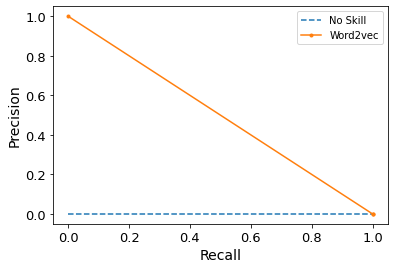

In [30]:
#precision-recall curve - compute precision-recall pairs for different probability thresholds
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(trs, prevs)

no_skill = trs.count(1) / len(trs)

#no-skill classifier
pyplot.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')

#word2vec classifier
pyplot.plot(recall, precision, marker = '.', label = 'Word2vec')

#labels
pyplot.xlabel('Recall', fontsize = 14)
pyplot.ylabel('Precision', fontsize = 14)

#ticks
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

#legend
pyplot.legend()

#save
#plt.savefig(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Transfers/Profiles/prcurve_transfers.png')

pyplot.show()